In [4]:
import argparse
from utils import ModelConfiguration, DataLoaderConfiguration
import os
from roar_experiment import experiment
from sensitive_transparency import sensitive_transparency
import torch
from pixel_perturbation_imagenet import create_folder, pixel_pertubation
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plot_results_pixel_perturbation import pixel_perburtation_results

torch.manual_seed(0)
PATH = os.getcwd() + '/'
device = torch.device('cuda:0')
save_path = PATH + 'results/'

Completeness test passed for FullGrad.
[1.0, 3.0, 5.0, 7.000000000000001, 10.0]


In [10]:
model_config = ModelConfiguration(epochs=10, learning_rate=0.1, checkpoint_path=PATH + 'saved-models/', device=device, model_name='RESNET-50', experiment='extra', num_classes=2)
if not os.path.exists('dataset/extra_experiment/'):
    print('dataset does not exist and needs to be downloaded!')
else:
    loader_config = DataLoaderConfiguration(datasetname='extra_experiment', batch_size=100, path=PATH, transform=EXTRA_TRANSFORM)

    sensitive_transparency(model_config, loader_config)



NameError: name 'EXTRA_TRANSFORM' is not defined

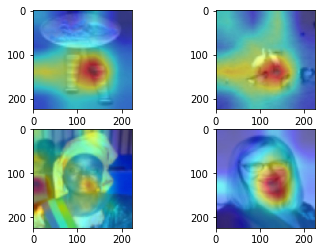

In [9]:
fix_shape = math.ceil(math.sqrt(len(os.listdir(save_path))))
fig=plt.figure()

for i, name in enumerate(os.listdir(save_path)):
    image = mpimg.imread(save_path + '/' + name)
    fig.add_subplot(fix_shape, fix_shape, i+1)
    plt.imshow(image)
plt.show()

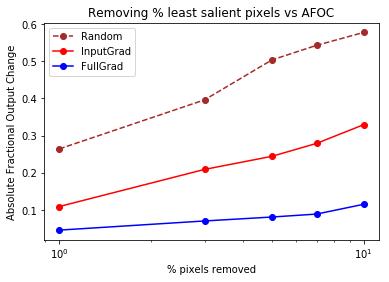

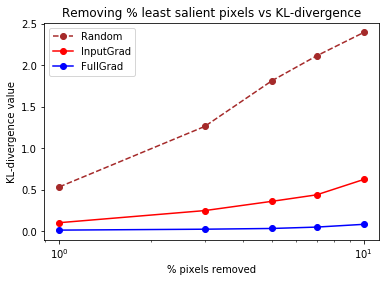

In [3]:
pixel_perburtation_results()

total_batches: 78 | total loss: 2.257 | epoch Acc: 55.390
total_batches: 78 | total loss: 1.992 | epoch Acc: 52.650
total_batches: 78 | total loss: 2.032 | epoch Acc: 49.620
total_batches: 78 | total loss: 1.869 | epoch Acc: 45.810
total_batches: 78 | total loss: 1.944 | epoch Acc: 36.620
total_batches: 78 | total loss: 1.653 | epoch Acc: 56.710
total_batches: 78 | total loss: 1.426 | epoch Acc: 53.600
total_batches: 78 | total loss: 1.450 | epoch Acc: 50.570
total_batches: 78 | total loss: 1.590 | epoch Acc: 46.920
total_batches: 78 | total loss: 1.978 | epoch Acc: 37.080
total_batches: 78 | total loss: 1.265 | epoch Acc: 56.840
total_batches: 78 | total loss: 1.439 | epoch Acc: 52.940
total_batches: 78 | total loss: 1.568 | epoch Acc: 51.080
total_batches: 78 | total loss: 1.539 | epoch Acc: 46.160
total_batches: 78 | total loss: 1.829 | epoch Acc: 34.910


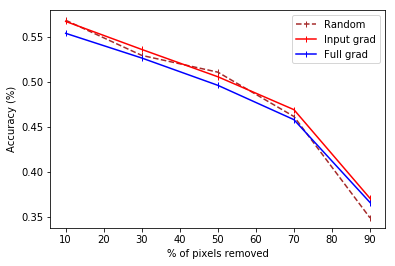

In [4]:
model_config = ModelConfiguration(epochs=80, learning_rate=0.01, device=device, checkpoint_path=PATH + 'saved-models/')
loader_config = DataLoaderConfiguration(path=PATH, data_dir='dataset/')
acc_list = experiment(model_config, loader_config)

x = [10, 30, 50, 70, 90]

plt.plot(x, acc_list[2], "--", marker = "|", c="brown",label = "Random")
plt.plot(x, acc_list[1], marker = "|", c="r", label = "Input grad")
plt.plot(x, acc_list[0], marker = "|", c="b", label = "Full grad")
plt.xlabel('% of pixels removed')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()